### VoxelMorph playground

**datasets**
* [mnist](https://pytorch.org/vision/stable/datasets.html)
* [fashionmnist](https://pytorch.org/vision/stable/datasets.html)
* [omniglot](https://pytorch.org/vision/stable/datasets.html)
* [morphomnist](https://github.com/dccastro/Morpho-MNIST)
* [caltech 101 silhouettes](https://people.cs.umass.edu/~marlin/data.shtml)

In [24]:
from __future__ import annotations
import voxelmorph as vm
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import random
print('numpy', np.__version__)
print('torch', torch.__version__)
print(sys.version)

numpy 1.21.2
torch 1.11.0
3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [2]:
data_dir = Path('datasets')
data_dir.mkdir(exist_ok=True)

### Mnist

In [40]:
mnist_dir = data_dir / 'mnist'
mnist_dir.mkdir(exist_ok=True)
mnist = torchvision.datasets.MNIST(root=mnist_dir, download=True)

### Fashionmnist

In [38]:
fashionmnist_dir = data_dir / 'fashionmnist'
fashionmnist_dir.mkdir(exist_ok=True)
fashionmnist = torchvision.datasets.FashionMNIST(root=fashionmnist_dir, download=True)

### Omniglot

In [39]:
omniglot_dir = data_dir / 'omniglot'
omniglot_dir.mkdir(exist_ok=True)
omniglot = torchvision.datasets.Omniglot(root=omniglot_dir, download=True)

Files already downloaded and verified


### partition by class

In [112]:
def filter_by_class(data, labels, class_to_keep: int = 0):
    indexer = labels == class_to_keep
    filtered_data = data[indexer]
    filtered_labels = labels[indexer]
    return filtered_data, filtered_labels

def partition_by_class(data, labels, classes):
    class_partitions = {}
    for k in classes:
        class_partitions[k] = filter_by_class(data, labels, k)
    return class_partitions
       

In [119]:
mnist_data = mnist.data.numpy()
mnist_labels = mnist.targets.numpy()
mnist_classes = np.unique(mnist_labels)
mnist_partitions = partition_by_class(mnist_data, mnist_labels, mnist_classes)

In [128]:
fashionmnist_data = fashionmnist.data.numpy()
fashionmnist_labels = fashionmnist.targets.numpy()
fashionmnist_classes = np.unique(fashionmnist_labels)
fashionmnist_partitions = partition_by_class(fashionmnist_data, fashionmnist_labels, fashionmnist_classes)

### split data

In [127]:
def get_data_split(data, labels, val_split=0.1, test_split=0.2):
    data = np.asarray(data)
    labels = np.asarray(labels)
    n = data.shape[0]
    assert n == labels.shape[0]
    index = list(range(n))
    random.shuffle(index)
    num_test = round(test_split * n)
    num_dev = n - num_test
    num_val = round(num_dev * val_split)
    num_train = num_dev - num_val
    train_index = index[:num_train]
    val_index = index[num_train:num_train+num_val]
    test_index = index[-num_test:]
    return {
        'train_data': data[train_index],
        'train_labels': labels[train_index],
        'val_data': data[val_index],
        'val_labels': labels[val_index],
        'test_data': data[test_index],
        'test_labels': labels[test_index],
    }

In [129]:
five_data = mnist_partitions[5]
five_split = get_data_split(*five_data)

In [131]:
sneaker_data = fashionmnist_partitions[7]
sneaker_split = get_data_split(*sneaker_data)

### dataset class

In [132]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        data: np.ndarray, 
        labels: np.ndarray, 
        normalize: bool = True,
        pad: None | tuple[int, int] = (32, 32), 
        transforms: None | list[torchvision.transforms] = [
            # torchvision.transforms.Pad((32, 32), fill=0),
            torchvision.transforms.ToTensor(),
        ],
    ):
        self.data = data
        self.labels = labels
        self.normalize = normalize
        self.pad = pad
        self.transforms = torchvision.transforms.Compose(transforms)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]
        if self.transforms:
            image = self.transforms(image)
        if self.pad:
            # only handles case when pad > size
            w, h = image.squeeze().shape
            assert self.pad[0] >= w, 'width padding too small'
            assert self.pad[1] >= h, 'height padding too small'
            w_diff = self.pad[0] - w
            h_diff = self.pad[1] - h
            w_pad = w_diff // 2
            h_pad = h_diff // 2
            padding = w_pad, w_diff - w_pad, h_pad, h_diff - h_pad
            image = torch.nn.functional.pad(image, padding, 'constant', 0)
        return image, label
    
    def normalize(self, arr):
        pass

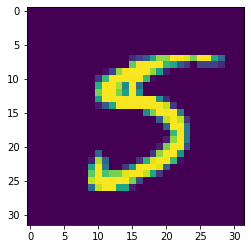

In [135]:
five_train_dataset = Dataset(five_split['train_data'], five_split['train_labels'])
five_val_dataset = Dataset(five_split['val_data'], five_split['val_labels'])
five_test_dataset = Dataset(five_split['test_data'], five_split['test_labels'])
plt.imshow(five_train_dataset[0][0][0])

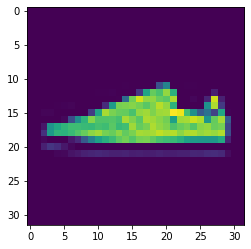

In [136]:
sneaker_train_dataset = Dataset(sneaker_split['train_data'], sneaker_split['train_labels'])
sneaker_val_dataset = Dataset(sneaker_split['val_data'], sneaker_split['val_labels'])
sneaker_test_dataset = Dataset(sneaker_split['test_data'], sneaker_split['test_labels'])
plt.imshow(sneaker_train_dataset[0][0][0])

### voxelmorph model